### Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

### Functions

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Data Preprocessing

In [3]:
data = pd.read_csv('./Data/resultAnalysis.csv', sep = ';', encoding = 'cp1254')
data.head()

,Datetime,PJM_Load_MW,Weekday,Date,Year,Month,Season,Day,Time,Hour,Minute,Week,DayOfWeek,LeapYear
0,1998-04-01 00:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-04-01 01:00:00,2,Wednesday,1998-04-01,1998.0,4.0,Spring,1.0,01:00:00,1.0,0.0,14.0,2.0,False
2,1998-04-01 02:00:00,2,Wednesday,1998-04-01,1998.0,4.0,Spring,1.0,02:00:00,2.0,0.0,14.0,2.0,False
3,1998-04-01 03:00:00,2,Wednesday,1998-04-01,1998.0,4.0,Spring,1.0,03:00:00,3.0,0.0,14.0,2.0,False
4,1998-04-01 04:00:00,2,Wednesday,1998-04-01,1998.0,4.0,Spring,1.0,04:00:00,4.0,0.0,14.0,2.0,False


In [4]:
data.dtypes

Datetime        object
PJM_Load_MW      int64
Weekday         object
Date            object
Year           float64
Month          float64
Season          object
Day            float64
Time            object
Hour           float64
Minute         float64
Week           float64
DayOfWeek      float64
LeapYear        object
dtype: object

In [5]:
data.Datetime = pd.to_datetime(data.Datetime)
data = data.sort_values(by = ['Datetime']).reset_index(drop= True)
data.dtypes

Datetime       datetime64[ns]
PJM_Load_MW             int64
Weekday                object
Date                   object
Year                  float64
Month                 float64
Season                 object
Day                   float64
Time                   object
Hour                  float64
Minute                float64
Week                  float64
DayOfWeek             float64
LeapYear               object
dtype: object

In [6]:
# Converting to Datetime format
df_data = data[['Datetime','PJM_Load_MW']].set_index('Datetime')
df_data

,PJM_Load_MW
Datetime,
1998-04-01 00:00:00,2
1998-04-01 01:00:00,2
1998-04-01 02:00:00,2
1998-04-01 03:00:00,2
1998-04-01 04:00:00,2
...,...
2001-12-31 19:00:00,4
2001-12-31 20:00:00,4
2001-12-31 21:00:00,4


In [7]:
# Converting the data to monthly based
df_data = pd.DataFrame(columns = ['Date', 'Month', 'PJM_Load_MW'])
df_data['Year'] = data['Datetime'].dt.year
df_data['Month'] = data['Datetime'].dt.month
df_data['PJM_Load_MW'] = data['PJM_Load_MW'].copy()
df_data = df_data.groupby(['Year','Month'])['PJM_Load_MW'].sum().reset_index()
df_data['Date'] = df_data.apply(lambda x: str(x['Year']) + '-' + str(x['Month']), axis = 1)
df_data['Date'] = pd.to_datetime(df_data['Date'])
df_data = df_data.set_index('Date')
df_data.drop(['Year','Month'], axis = 1, inplace = True)
df_data

,PJM_Load_MW
Date,
1998-04-01,1842
1998-05-01,1975
1998-06-01,2138
1998-07-01,2426
1998-08-01,2469
1998-09-01,2122
1998-10-01,1916
1998-11-01,1880
1998-12-01,2105


In [8]:
df_data_x = df_data['1998-04-01':'2001-03-01']
len(df_data_x)

36

In [9]:
df_data_y = df_data['2001-04-01':]
len(df_data_y)

9

### Forecasting

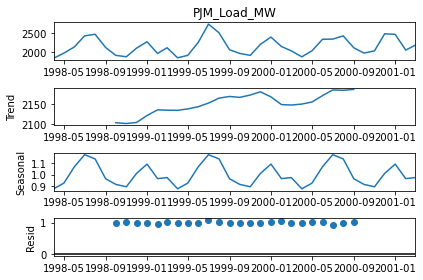

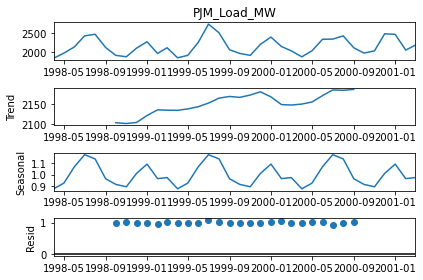

In [10]:
result_a = seasonal_decompose(df_data_x['PJM_Load_MW'], model = 'multiplicative')
result_a.plot()

In [11]:
# Hyperparameter tuning for p, d, q, P, D, Q values
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_data_x,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - MSE:{}'.format(param,param_seasonal,results.mse))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MSE:4690623.777777778
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MSE:2622843.9567746953
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - MSE:2446812.8674963242
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MSE:1499790.4444444445
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MSE:1498878.154917811
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - MSE:1499790.4444444445
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - MSE:1874095.5710575883
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - MSE:2118534.117437229
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - MSE:2117792.820018298
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MSE:1498652.443524692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MSE:1496006.8666489634
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - MSE:1500705.5749496736
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MSE:1664967.3566204775
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MSE:1708441.580771929
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - MSE:1499790.4444444445
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - MSE:2119397.1930826064
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - MSE:2118534.117437229
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - MSE:2117792.820018298


ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - MSE:340367.39031010657
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - MSE:353210.6303786694
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - MSE:356138.6169120761
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - MSE:159405.35899464795
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - MSE:158562.94277136517
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - MSE:153636.4209036155
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - MSE:186348.59919175744
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - MSE:186348.59919175744
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - MSE:187839.957095261
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - MSE:352720.15600053687
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - MSE:352720.15600053687
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - MSE:356138.6169120761
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - MSE:222434.36111111112
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - MSE:212553.60654169944
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - MSE:218011.72201656963
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - MSE:253323.2032281419
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - MSE:259482.39789656064
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - MSE:274475.55695128936

ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - MSE:142950.00806599366
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - MSE:1420605.3031602807
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - MSE:1456636.585148007
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - MSE:2095584.798723275
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - MSE:1958194.269294988
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - MSE:2274105.662408594
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - MSE:2313936.7491235365
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - MSE:501807.08600958926
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - MSE:208632.68582376133
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - MSE:176925.8509673266
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - MSE:2882016.203826445
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - MSE:1908477.7279536505
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - MSE:2095584.798723275
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - MSE:2267150.809080594
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - MSE:2274105.662408594
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - MSE:2313936.7491235365
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - MSE:215479.347823242
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - MSE:219879.55661309022
ARI

ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - MSE:233242.02629494749
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - MSE:234319.18499933995
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - MSE:234835.66195857085
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - MSE:272568.11004017264
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - MSE:272568.11004017264
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - MSE:273231.8591410608
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - MSE:448019.0217666833
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - MSE:448019.0217666833
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - MSE:446961.6426662954
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - MSE:174200.71875862367
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - MSE:178963.05989782175
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - MSE:202352.9170321289
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - MSE:234415.38812395823
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - MSE:231086.7035640121
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - MSE:240467.64347105075
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - MSE:409165.96553375485
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - MSE:1665443.7179906585
ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - MSE:1692283.937537517

ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - MSE:326379.03755359474
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - MSE:352866.2307004988
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - MSE:354772.46084173466
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - MSE:151563.8501976709
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - MSE:152436.82118876392
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - MSE:164531.6231983871
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - MSE:218281.5262714145
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - MSE:221890.07677539406
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - MSE:194834.8665271373
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - MSE:352866.2307004988
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - MSE:352866.2307004988
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - MSE:354772.46084173466
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - MSE:195328.72240052625
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - MSE:195418.06634831906
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - MSE:195823.72573563128
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - MSE:194834.8665271373
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - MSE:194834.8665271373
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - MSE:194834.8665271373
AR

In [12]:
# Building the model and forecasting
model = SARIMAX(df_data_x['PJM_Load_MW'], order = (1,1,1), seasonal_order = (0,1,0,12))
model_fit = model.fit()
model_fit.forecast(len(df_data_y))

2001-04-01    1943.302487
2001-05-01    2087.363619
2001-06-01    2387.014189
2001-07-01    2390.618187
2001-08-01    2474.551440
2001-09-01    2164.540189
2001-10-01    2023.538293
2001-11-01    2082.537973
2001-12-01    2529.537920
Freq: MS, Name: predicted_mean, dtype: float64

In [13]:
# Get MAPE score for the model
mape(model_fit.forecast(len(df_data_y)), df_data_y)

11.890338712057346

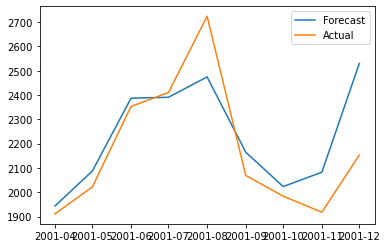

In [14]:
plt.plot(model_fit.forecast(len(df_data_y)), label='Forecast')
plt.plot(df_data_y, label='Actual')
plt.legend(prop={'size': 10})
#matplotlib.rc('xtick', labelsize=35) 
#matplotlib.rc('ytick', labelsize=35)
plt.show()